In [1]:
import onnx 
import onnxruntime 
import cv2 
import matplotlib.pyplot as plt 

In [11]:
model_path = '/media/altex/XcDrive/MScProject/torchModels/train320_new/exp0/weights/last.onnx'

In [12]:
sess = onnxruntime.InferenceSession(model_path)

In [13]:
print([inp.name for inp in sess.get_inputs()])

['images']


In [14]:
print([outp.name for outp in sess.get_outputs()])

['outputs', 'grid8', 'grid16', 'grid32']


In [15]:
print([outp.shape for outp in sess.get_outputs()])

[[1, 6300, 8], [1, 3, 40, 40, 8], [1, 3, 20, 20, 8], [1, 3, 10, 10, 8]]


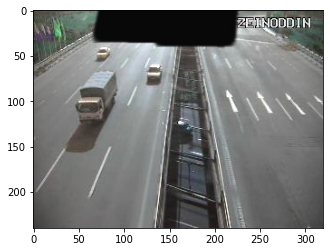

In [16]:
import glob 
images_path = glob.glob('/home/altex/test_images/*.jpg')
img = cv2.imread(images_path[0])
plt.imshow(img)

In [22]:
import numpy as np 
def preprocess(x, size=(320,320)):  
    temp = np.zeros((size[0],size[1],3),dtype=x.dtype)
    h,w, c = x.shape
    r = max([w/size[1],h/size[0]])
    x = cv2.resize(x,(int(w/r),int(h/r)))
    px = size[1] - int(w/r) 
    py = size[0] - int(h/r)
    temp[py//2:py//2+x.shape[0],px//2:px//2+x.shape[1],:] = x    
    img_ = np.transpose(temp,[2,0,1])
    img_ = np.reshape(img_,[1]+list(img_.shape))
    img_ = np.float32(img_)/255.
    return img_ 

In [112]:
img1 = preprocess(img)
import time 
t0 = time.time_ns()
onnx_output = sess.run(['outputs'], {'images':img1})
print('graph time = ', 1e-6*(time.time_ns()-t0))

graph time =  9.1282


In [265]:
def calculateScaling(x, size):
    h,w, c = x.shape
    r = max([w/size[1],h/size[0]])
    x = cv2.resize(x,(int(w/r),int(h/r)))
    px = size[1] - int(w/r) 
    py = size[0] - int(h/r)
    return (px//2,py//2), r

def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y =  np.zeros_like(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y
def nms(boxes, scores, iou_thresh):
    boxes = np.reshape(boxes, [boxes.shape[0],1,boxes.shape[1]])
    xmins = np.maximum(boxes[...,0], boxes[:,0,0])
    ymins = np.maximum(boxes[...,1], boxes[:,0,1])
    xmaxs = np.minimum(boxes[...,2], boxes[:,0,2])
    ymaxs = np.minimum(boxes[...,3], boxes[:,0,3])
    hi = ymaxs-ymins
    wi = xmaxs-xmins
    intersections = wi * hi 
    intersections[wi<0] = 0
    intersections[hi<0] = 0 
    union = (boxes[:,0,2:3]-boxes[:,0,0:1])*(boxes[:,0,3:4]-boxes[:,0,1:2])
    union =  union + union.T
    ious = intersections/(union-intersections+1e-5)
    sorted_scores = np.argsort(np.max(scores,1),0)
    final_boxes = []
    final_scores = []
    for i in range(sorted_scores.shape[0]-1,-1,-1):
        idx = sorted_scores[i]
        valid = True 
        for k in range(i+1,sorted_scores.shape[0],1):
            id2 = sorted_scores[k]
            #print(idx, id2, ious[idx,id2])
            if ious[idx][id2]>iou_thresh:
                valid = False 
                break
        if valid:
            final_scores.append(scores[idx])
            final_boxes.append(boxes[idx][0])
    return np.array(final_boxes), np.array(final_scores)

def PostProcess(predictions, conf_thresh=0.5, iou_thresh=0.4):
    nc = predictions[0].shape[1] - 5  # number of classes
    xc = predictions[..., 4] > conf_thresh  # candidates
    output = [None] * predictions.shape[0]
    for xi, x in enumerate(predictions):
        x = x[xc[xi]]
        if not x.shape[0]:
            continue 
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
        box = xywh2xyxy(x[:, :4])
        scores = x[:,5:] 
        box, scores = nms(box, scores, iou_thresh)
        output[xi] = (box, scores)
    return output
        

In [266]:
detections = PostProcess(onnx_output[0])

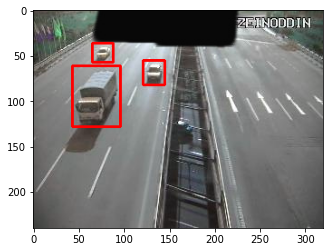

In [267]:
bboxes, scores = detections[0]
img = cv2.imread(images_path[0])
pad, scale = calculateScaling(img, (320,320))
for i in range(bboxes.shape[0]):
    box = bboxes[i].copy()
    cls = np.argmax(scores[i]) 
    score = scores[i][cls]
    box[0] = box[0]-pad[0]
    box[2] = box[2]-pad[0]
    box[1] = box[1]-pad[1]
    box[3] = box[3]-pad[1]
    box *= scale
    box = box.astype(np.int)
    
    cv2.rectangle(img, (box[0],box[1]), (box[2],box[3]),(255,0,0),2)
plt.imshow(img)
    

In [262]:
detections

[(array([[ 43.174675, 101.535904,  96.404945, 168.26857 ],
         [121.88245 ,  95.64818 , 145.16241 , 122.45247 ],
         [ 65.79042 ,  76.42118 ,  88.45976 ,  97.29003 ]], dtype=float32),
  array([[0.00153818, 0.92897815, 0.00374133],
         [0.04526481, 0.7454444 , 0.02132291],
         [0.31209573, 0.58612984, 0.00416105]], dtype=float32))]

In [255]:
scores

array([[0.2973255 , 0.5753823 , 0.00588244]], dtype=float32)

In [234]:
boxes = np.random.randint(90, 100,(3,4))
scores = np.random.randn(4,3)
boxes = xywh2xyxy(boxes)

In [237]:
np.argmax(scores,1).shape

(4,)

In [197]:
boxes = np.reshape(boxes, [boxes.shape[0],1,boxes.shape[1]])

In [198]:
boxes.shape

(3, 1, 4)

0 2 0.9114795110921912
1 0 0.8234251960399358
1 2 0.8824421299075689


In [220]:
final_scores

[1.7385203430698324, 1.121310506889033]

In [205]:
ious

array([[1.        , 0.8234252 , 0.91147951],
       [0.8234252 , 1.        , 0.88244213],
       [0.91147951, 0.88244213, 1.        ]])

In [213]:
sorted_scores

array([1, 0, 2])

In [214]:
scores

array([1.21871694, 1.12131051, 1.73852034])